<h1>HMM Gaussian Distributions</h1><br>
This script is used to model and generate both the RHS distribution and the ordering distribution using a Hidden Markov Model. Switching between the two is a matter of tweaking parameters.

# Licence
BSD 3-Clause License

Copyright (c) 2020, Cyber Security Research Centre Limited
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.



<h2>Setup</h2>

In [1]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

In [2]:
#convenience variables
sec = 1000000000
split_time = 0.00025

#tweakable parameters
data_csv = 'data.csv'  #the raw data
c_id = 4               #client to generate a distribution for
n_components = 25      #components in the HMM distribution
ordering_model = False #True: generates an ordering HMM. False: generates a RHS distribution HMM
max_iterations = 40    #maximum iterations for HMM training
num_samples = 270000   #how many data points to generate during simulation

#file names
RHS_dist_file = f"HMM_{n_components}_RHS_dist_c{c_id}.npz" #save
RHS_model_file = f"HMM_{n_components}_RHS_model_c{c_id}.pkl" #save
ordering_dist_file = f"HMM_{n_components}_ordering_dist_c{c_id}.npz" #save
ordering_model_file = f"HMM_{n_components}_ordering_model_c{c_id}.pkl" #save
dist_folder = "saved_dist"
model_folder = "saved_model"

<h2>Data Loading</h2>

In [3]:
#prepend the folder location
RHS_dist_file = os.path.join(dist_folder, RHS_dist_file)
RHS_model_file = os.path.join(model_folder, RHS_model_file)
ordering_dist_file = os.path.join(dist_folder, ordering_dist_file)
ordering_model_file = os.path.join(model_folder, ordering_model_file)

#load the raw data
X = pd.read_csv(data_csv)
orig_times = X[(X.client_id == c_id)].time.apply(lambda x:x/sec) #convert to seconds
orig_delta = np.ediff1d(orig_times)

#RHS distribution
if (not ordering_model):
    orig_delta = orig_delta[orig_delta > split_time] #after the split
    delta_min = np.min(orig_delta)
    orig_delta = orig_delta - delta_min
#ordering distribution
else:
    orig_delta = np.array(list(map((lambda x: 1 if x > split_time else 0), orig_delta)))

<h2>Training</h2>

In [4]:
#n_components = number of states
model = hmm.GaussianHMM(n_components=n_components, verbose=True, n_iter=max_iterations).fit(orig_delta.reshape((len(orig_delta),1)))

         1     -682675.0803             +nan
         2     -421490.2271     +261184.8532
         3     -331509.2830      +89980.9441
         4     -205429.5325     +126079.7505
         5     -101900.4034     +103529.1291
         6      -60878.9681      +41021.4352
         7       29289.2845      +90168.2526
         8      153440.0451     +124150.7606
         9      251796.6635      +98356.6185
        10      355774.6131     +103977.9496
        11      391319.9880      +35545.3749
        12      401264.3426       +9944.3546
        13      404543.3488       +3279.0063
        14      406409.2722       +1865.9234
        15      407985.3647       +1576.0925
        16      409354.6573       +1369.2926
        17      410413.5803       +1058.9230
        18      411269.3297        +855.7495
        19      412083.5920        +814.2623
        20      412964.6801        +881.0881
        21      413895.3351        +930.6550
        22      414697.6874        +802.3523
        23

<h2>Simulation</h2>

In [5]:
# Generate samples
new_X, Z = model.sample(num_samples)

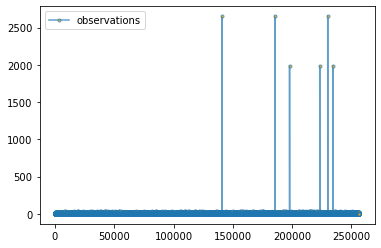

In [6]:
a = new_X[:, 0]

#save everything
#RHS distribution
if (not ordering_model):
    a = a[a > 0]+ delta_min
    np.savez(RHS_dist_file, deltas=a)
    with open(RHS_model_file, "wb") as file: pickle.dump(model, file)
#ordering distribution
else:
    a = np.round(a)
    np.savez(ordering_dist_file, dist=a)
    with open(ordering_model_file, "wb") as file: pickle.dump(model, file)

# Plot the sampled data
plt.plot(a, ".-", label="observations", ms=6,
         mfc="orange", alpha=0.7)

plt.legend(loc='best')
plt.show()